#  **Heart Failure Clinical Records Dataset Feature Engineering**

**Objective**  
Prepare the dataset for robust machine learning by applying preprocessing steps such as encoding, transformations, scaling, binning, and feature creation. Final output will be a train-test split ready for modeling.

In [1]:
import os
import warnings


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns


from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler


sns.set(style='whitegrid', font_scale=1.2)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

SEED = 42

In [2]:
data_path = "../data/raw/heart_failure_clinical_records_dataset.csv"
df = pd.read_csv(data_path)

In [3]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  death_event               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [5]:
binary_cols = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'death_event']
for col in binary_cols:
    print(f"{col}:\n{df[col].value_counts(normalize=True)}\n")

anaemia:
anaemia
0    0.568562
1    0.431438
Name: proportion, dtype: float64

diabetes:
diabetes
0    0.58194
1    0.41806
Name: proportion, dtype: float64

high_blood_pressure:
high_blood_pressure
0    0.648829
1    0.351171
Name: proportion, dtype: float64

sex:
sex
1    0.648829
0    0.351171
Name: proportion, dtype: float64

smoking:
smoking
0    0.67893
1    0.32107
Name: proportion, dtype: float64

death_event:
death_event
0    0.67893
1    0.32107
Name: proportion, dtype: float64



In [6]:
df.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
death_event                 0
dtype: int64

No missing values detected. Binary features are already encoded as 0/1.

##  **Age Binning Using Quantiles**

Text(0.5, 1.0, 'Death Event by Age Group')

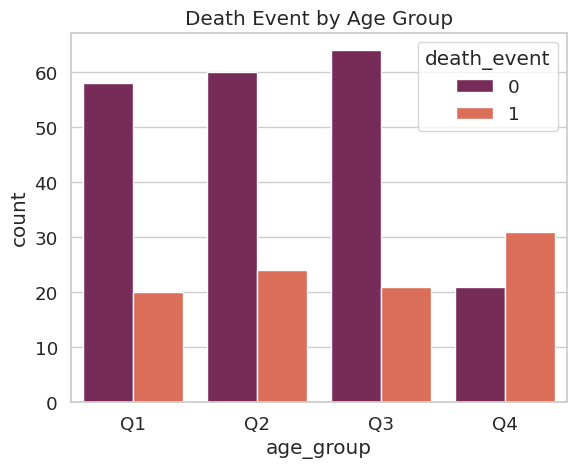

In [7]:
df["age_group"] = pd.qcut(df["age"], q=4, labels=["Q1","Q2","Q3","Q4"])

sns.countplot(x='age_group', hue='death_event', data=df, palette='rocket')
plt.title("Death Event by Age Group")


In [8]:
encoder = OneHotEncoder(sparse_output=False, drop=None)
encoded_age_group = encoder.fit_transform(df[['age_group']])
age_group_cols = encoder.get_feature_names_out(['age_group'])
encoded_df = pd.DataFrame(encoded_age_group, columns=age_group_cols, index=df.index)
df = pd.concat([df.drop('age_group', axis=1), encoded_df], axis=1)


Age stratification can improve model interpretability and capture nonlinear effects.

##  **Log Transformation for Skewed Features**

In [9]:
print("The original skewness is", df['creatinine_phosphokinase'].skew())

The original skewness is 4.463110084653752


In [10]:
df['cpk_log'] = np.log1p(df['creatinine_phosphokinase'])

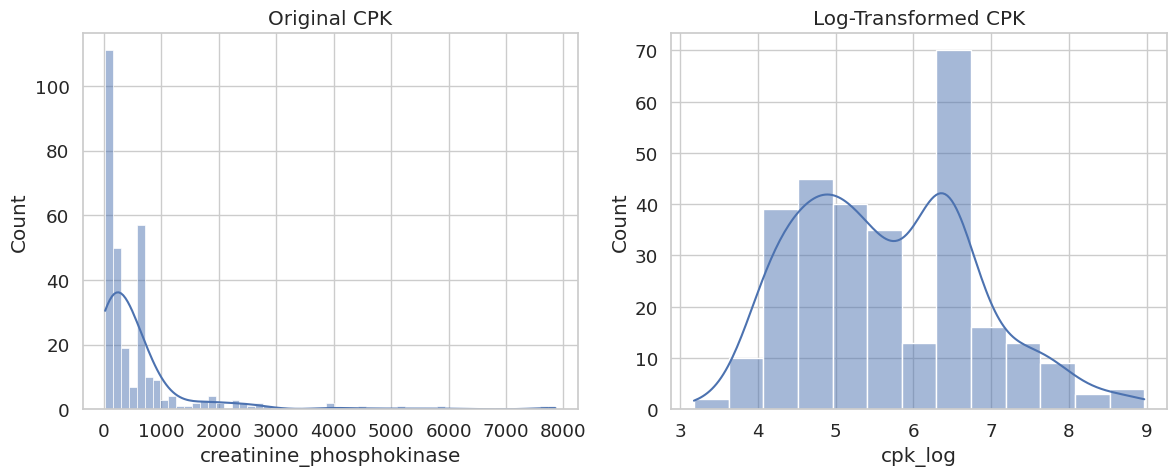

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['creatinine_phosphokinase'], ax=ax[0], kde=True, palette='rocket')
ax[0].set_title("Original CPK")
sns.histplot(df['cpk_log'], ax=ax[1], kde=True, palette='rocket')
ax[1].set_title("Log-Transformed CPK")
plt.tight_layout()

In [12]:
df.drop(columns="creatinine_phosphokinase", inplace=True)

The log-transformation reduces heavy right skew in CPK distribution, helping stabilize variance and improve model learning.

## **Standardize Continuous Features**

In [13]:
scaler = StandardScaler()

numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

continuous_vars = [col for col in numeric_cols if df[col].nunique() > 10]

df_scaled = df.copy()
df_scaled[continuous_vars] = scaler.fit_transform(df[continuous_vars])

df_scaled[continuous_vars].describe().T


,count,mean,std,min,25%,50%,75%,max
age,299.0,5.703353e-16,1.001676,-1.754448,-0.828124,-0.070223,0.771889,2.877170
ejection_fraction,299.0,-3.267546e-17,1.001676,-2.038387,-0.684180,-0.007077,0.585389,3.547716
platelets,299.0,7.723291e-17,1.001676,-2.440155,-0.520870,-0.013908,0.411120,6.008180
serum_creatinine,299.0,1.425838e-16,1.001676,-0.865509,-0.478205,-0.284552,0.005926,7.752020
serum_sodium,299.0,-8.673849e-16,1.001676,-5.363206,-0.595996,0.085034,0.766064,2.582144
time,299.0,-1.901118e-16,1.001676,-1.629502,-0.739000,-0.196954,0.938759,1.997038
cpk_log,299.0,1.366428e-16,1.001676,-2.206211,-0.797646,-0.124452,0.622916,2.930118


##  **Feature Correlation Matrix**

Text(0.5, 1.0, 'Feature Correlation Heatmap')

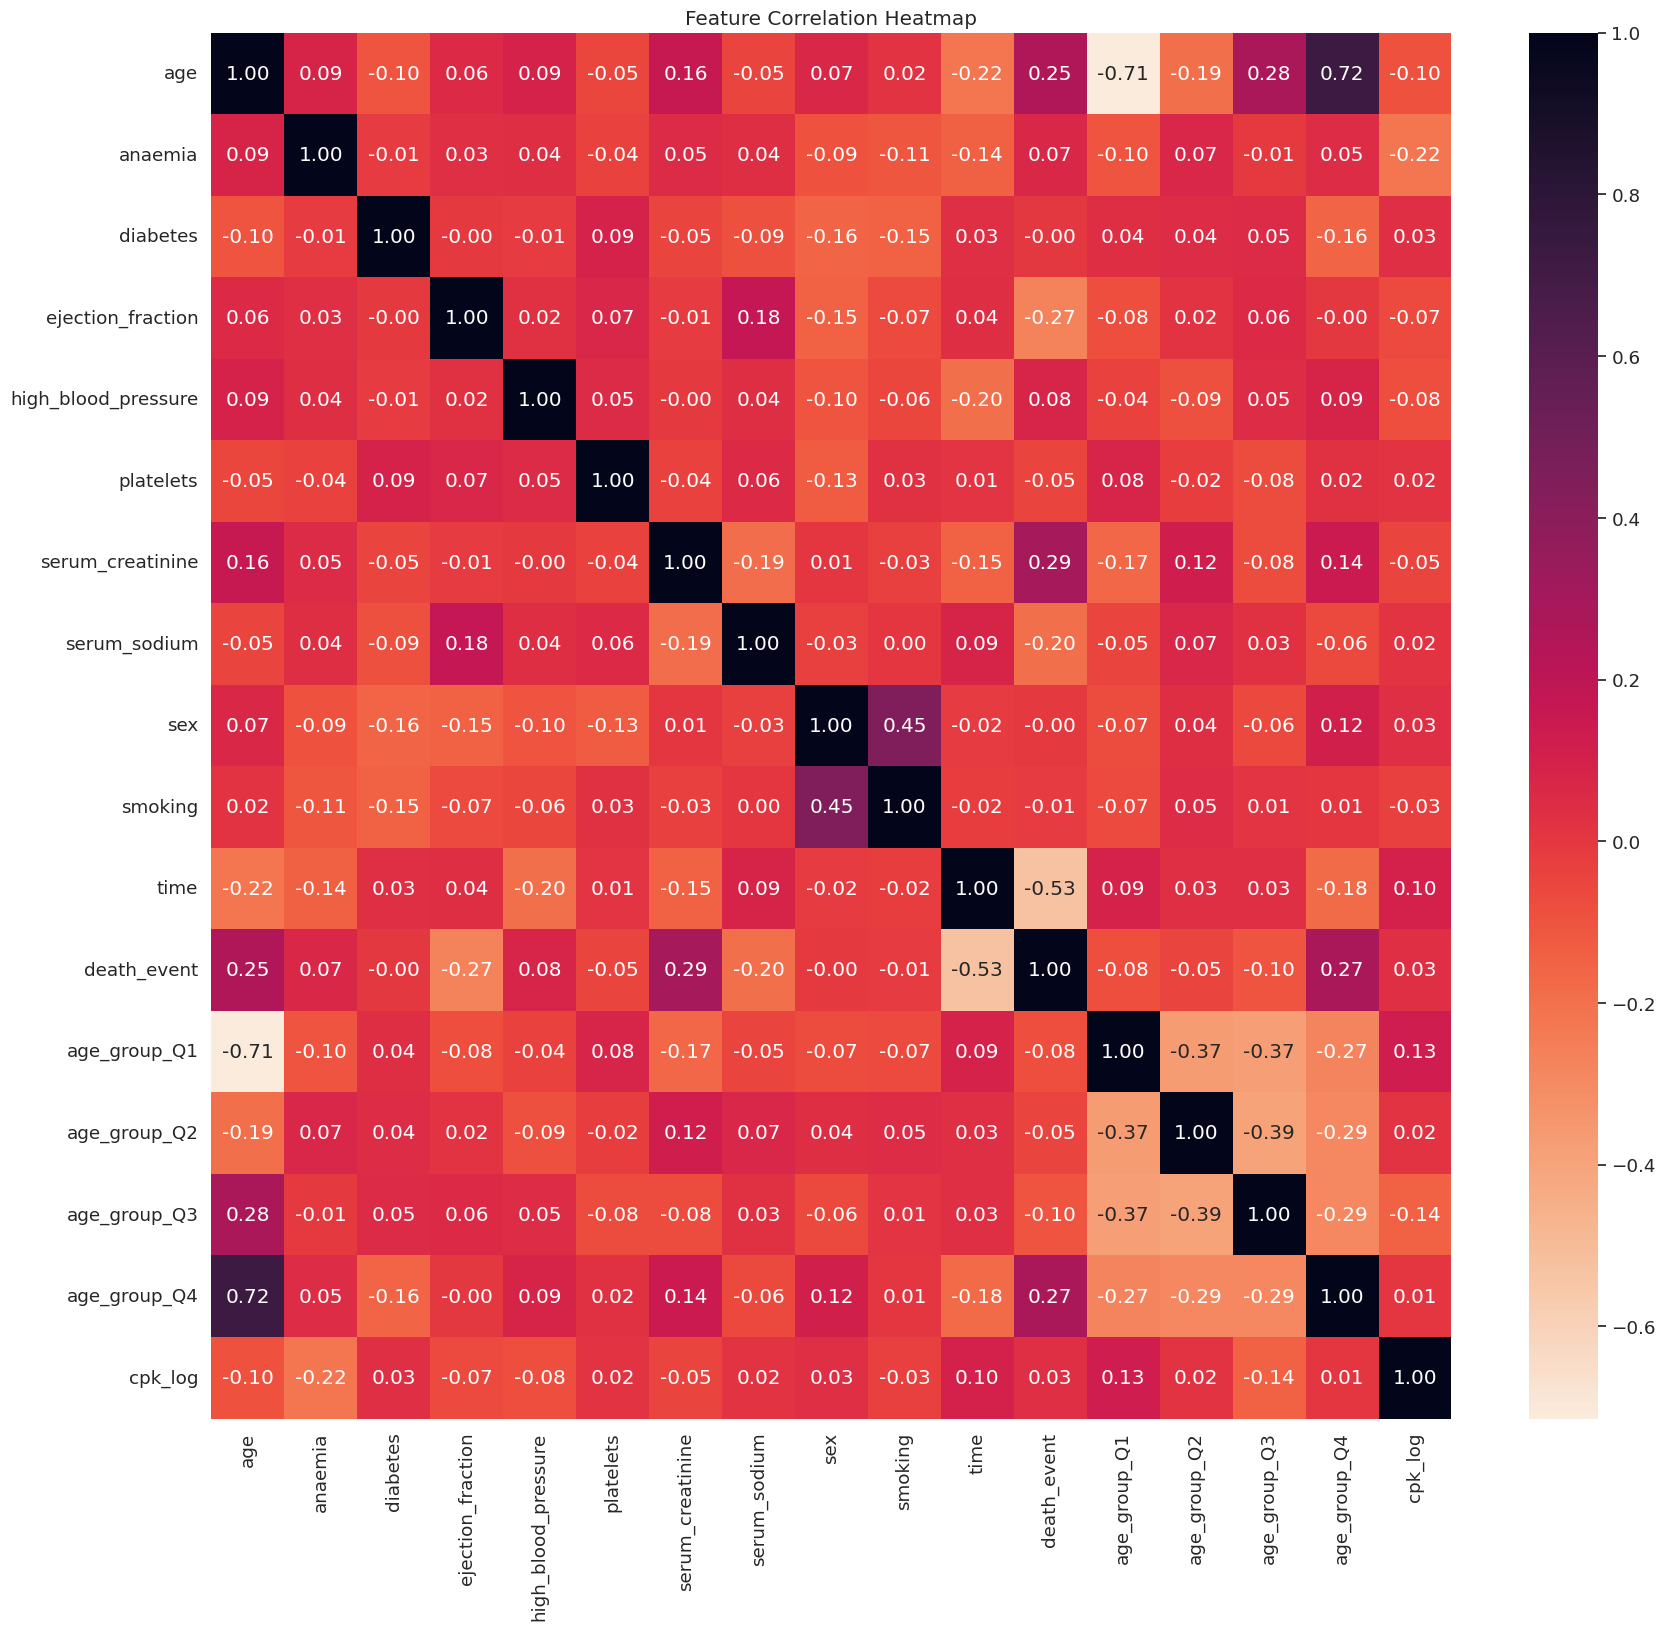

In [14]:
plt.figure(figsize=(20, 18))
sns.heatmap(df_scaled.corr(), annot=True, fmt=".2f", cmap="rocket_r")
plt.title("Feature Correlation Heatmap")


Ejection fraction and death event exhibit a negative correlation, confirming that higher ejection fraction values are protective against mortality. In contrast, serum creatinine shows a positive correlation with death event, indicating that elevated creatinine levels are associated with increased risk of death. Additionally, the log-transformed creatinine phosphokinase (cpk_log) distribution appears more normalized and demonstrates a weak correlation with mortality.

##  **Train/Test Split** 

In [15]:
X = df_scaled.loc[:, df.columns != 'death_event']
y = df_scaled['death_event']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

print("Train shape is", X_train.shape)
print("Test shape is", X_test.shape)
print("Survival ratio in test set is")
print(y_test.value_counts(normalize=True))


Train shape is (239, 16)
Test shape is (60, 16)
Survival ratio in test set is
death_event
0    0.683333
1    0.316667
Name: proportion, dtype: float64


**Preprocessing and Feature Engineering**

Binary features were properly encoded and cleaned to ensure consistency in modeling. The highly skewed creatinine phosphokinase (CPK) values were log-transformed to improve their distribution and model stability. Age was binned into three quantile-based groups to capture potential non-linear effects while preserving distribution balance.


**Scaling and Correlation Analysis**

All continuous variables were scaled to standardize their range and improve model convergence. Correlation analysis was performed to assess multicollinearity and identify variables with strong predictive signal.


**Data Splitting**

A stratified train/test split was conducted to maintain class balance across subsets, and the resulting datasets were saved for downstream modeling.


In [16]:
X_train.to_csv("../data/processed/X_train.csv", index=False)
X_test.to_csv("../data/processed/X_test.csv", index=False)
y_train.to_csv("../data/processed/y_train.csv", index=False)
y_test.to_csv("../data/processed/y_test.csv", index=False)
